## Configurable parameters

## Build graph (adjacency matrix) from GRM

In [1]:
import pyreadr
import numpy as np
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sp

def grm_to_adjacency(GRM_df, k=3, weighted=False):
    """
    Build adjacency matrix (sparse) from GRM using kNN.
    
    GRM_df: pd.DataFrame, index and columns are IDs
    k: int, number of neighbors
    weighted: bool, if True use GRM similarity as weights, else binary

    returns: scipy sparse adjacency (CSR)
    """
    # --- Load GRM ---
    ids = GRM_df.index.to_numpy().astype(str)
    G = GRM_df.to_numpy().astype(float)

    # --- Normalize (cosine-like) ---
    diag = np.clip(np.diag(G), 1e-12, None)
    D = np.sqrt(np.outer(diag, diag))
    G_norm = G / D
    G_norm = np.clip(G_norm, -1.0, 1.0)

    # --- kNN search ---
    dist = 1.0 - G_norm   # similarity → distance
    nbrs = NearestNeighbors(n_neighbors=k+1, metric="precomputed").fit(dist)
    dists, neigh = nbrs.kneighbors(dist)

    rows, cols, data = [], [], []
    for i in range(len(ids)):
        for j in neigh[i][1:]:  # skip self
            rows.append(i)
            cols.append(j)
            if weighted:
                data.append(G_norm[i, j])
            else:
                data.append(1.0)

    A = sp.csr_matrix((data, (rows, cols)), shape=(len(ids), len(ids)))
    return A


## Figure (for fun)

In [ ]:
import pyreadr
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_grm_graph(grm_file, pheno_file, subset_size=100, k=5, seed=42):
    """
    Plot kNN graph from GRM, coloring nodes by adjusted phenotype.

    grm_file: str, path to GRM RDS file
    pheno_file: str, CSV with columns ["ringnr", "y_adjusted"]
    subset_size: int, number of individuals to plot
    k: int, nearest neighbors
    """
    # --- Load GRM ---
    grm_res = pyreadr.read_r(grm_file)
    GRM_df = grm_res[None]
    ids = GRM_df.index.to_numpy().astype(str)
    G = GRM_df.to_numpy().astype(float)

    # --- Load phenotypes ---
    pheno = pd.read_csv(pheno_file)
    pheno = pheno.set_index("ringnr").loc[ids]  # align order
    y = pheno["y_adjusted"].to_numpy()

    # --- Subset ---
    np.random.seed(seed)
    subset = np.random.choice(len(ids), min(subset_size, len(ids)), replace=False)
    G = G[np.ix_(subset, subset)]
    ids = ids[subset]
    y = y[subset]

    # --- Normalize GRM (cosine-like) ---
    diag = np.clip(np.diag(G), 1e-12, None)
    D = np.sqrt(np.outer(diag, diag))
    G_norm = G / D
    G_norm = np.clip(G_norm, -1.0, 1.0)

    # --- Build kNN graph ---
    dist = 1.0 - G_norm
    nbrs = NearestNeighbors(n_neighbors=k+1, metric="precomputed").fit(dist)
    dists, neigh = nbrs.kneighbors(dist)

    edges = []
    for i in range(len(ids)):
        for j in neigh[i][1:]:   # skip self
            edges.append((i, j))

    # --- Build NetworkX graph ---
    G_nx = nx.Graph()
    for i, node in enumerate(ids):
        G_nx.add_node(i, ringnr=node, phenotype=y[i])
    G_nx.add_edges_from(edges)

    # --- Plot ---
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G_nx, seed=seed)

    # color by phenotype
    node_colors = [d["phenotype"] for _, d in G_nx.nodes(data=True)]
    nodes = nx.draw_networkx_nodes(G_nx, pos,
                                   node_size=80,
                                   node_color=node_colors,
                                   cmap=plt.cm.viridis)
    nx.draw_networkx_edges(G_nx, pos, alpha=0.3)

    plt.colorbar(nodes, label="Adjusted phenotype")
    plt.title(f"kNN graph (subset={len(ids)}, k={k})")
    plt.axis("off")
    plt.show()


# Example usage:
plot_grm_graph(
    grm_file="Data/gnn/GRM_vanraden_1000.rds",
    pheno_file="Data/gnn/adjusted_body_mass.csv",
    subset_size=100,
    k=3
)


## Model architecture

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def add_self_loops_csr(A: sp.csr_matrix):
    n = A.shape[0]
    A = A.tolil()
    A.setdiag(1)                      # add I
    return A.tocsr()

def row_normalize_csr(A: sp.csr_matrix):
    # \hat{A} = D_row^{-1} A, where D_row[i,i] = sum_j A[i,j]
    d = torch.from_numpy(np.asarray(A.sum(axis=1)).ravel()).float()
    d[d == 0] = 1.0
    inv = 1.0 / d
    Dinv = sp.diags(inv.numpy())
    return Dinv.dot(A).tocsr()

def csr_to_torch_sparse(A: sp.csr_matrix):
    A = A.tocoo()
    indices = torch.tensor([A.row, A.col], dtype=torch.long)
    values = torch.tensor(A.data, dtype=torch.float32)
    return torch.sparse_coo_tensor(indices, values, torch.Size(A.shape)).coalesce()

class GCN_RS_Model(nn.Module):
    """
    A configurable GCN-style regressor:
      - Each hidden layer: H^{(l+1)} = Dropout( ReLU( BN( Linear( A @ H^{(l)} ) ) ) )
      - Final head: out = Linear(H^{(L)})
    Args
    ----
    input_dim: int
        Number of SNP features per individual.
    hidden_dims: list[int]
        Sizes of hidden layers (e.g., [128, 64]). Length = #graph conv layers.
    dropout: float
        Dropout probability applied after each hidden layer.
    use_batchnorm: bool
        If True, apply BatchNorm1d after Linear and before ReLU.
    """
    def __init__(self,
                 input_dim: int,
                 hidden_dims=(128, 64),
                 dropout: float = 0.5,
                 use_batchnorm: bool = True):
        super().__init__()
        self.dropout = dropout
        self.use_bn = use_batchnorm

        # Define dimensions from input through hidden layers
        dims = [input_dim] + list(hidden_dims)

        # Linear maps after graph aggregation
        self.linears = nn.ModuleList([
            nn.Linear(dims[i], dims[i+1], bias=True)
            for i in range(len(dims) - 1)
        ])

        # Optional BN per hidden layer
        if self.use_bn:
            self.bns = nn.ModuleList([nn.BatchNorm1d(d) for d in hidden_dims])
        else:
            self.bns = None

        # Final regression head
        self.head = nn.Linear(dims[-1], 1)

    def forward(self, X: torch.Tensor, A_norm: torch.Tensor) -> torch.Tensor:
        """
        X:       [N, F] dense features
        A_norm:  [N, N] torch.sparse_coo_tensor (row-normalized with self-loops)
        """
        H = X
        for i, lin in enumerate(self.linears):
            # Graph message passing
            H = torch.sparse.mm(A_norm, H)   # [N, d_in]
            H = lin(H)                       # [N, d_out]
            if self.use_bn:
                H = self.bns[i](H)           # BN on features
            H = F.relu(H)
            H = F.dropout(H, p=self.dropout, training=self.training)

        # Final linear head (no propagation here)
        out = self.head(H).squeeze(-1)       # [N]
        return out




In [18]:
def standardize_train_test(X, train_idx, test_idx):
    X_train = X[train_idx]
    mean = X_train.mean(0, keepdim=True)
    std = X_train.std(0, keepdim=True).clamp_min(1e-6)
    Xs = (X - mean) / std
    return Xs, mean, std

def standardize_y_train_test(y, train_idx, test_idx):
    y_train = y[train_idx]
    m = y_train.mean()
    s = y_train.std().clamp_min(1e-6)
    ys = (y - m) / s
    return ys, m, s

def subgraph_norm_to_sparse(A_full_csr: sp.csr_matrix, node_idx: np.ndarray) -> torch.Tensor:
    # Induce subgraph, then add self-loops, row-normalize, convert to torch.sparse
    A_sub = A_full_csr[node_idx][:, node_idx]
    A_sub = add_self_loops_csr(A_sub)
    A_sub = row_normalize_csr(A_sub)
    return csr_to_torch_sparse(A_sub)


## Training

### Load data

In [6]:
import pandas as pd

# ---------- SNP FEATURES ----------
snp_file = "../Data/gnn/SNP/ALL/snp_export_body_mass_ALL_geno.feather"
snp_df = pd.read_feather(snp_file)  # expects first column 'ringnr'

# ---------- PHENOTYPE ----------
pheno_file = "../Data/gnn/adjusted_body_mass.csv"
pheno_df = pd.read_csv(pheno_file)

# ---------- GRM ----------
grm_file = "../Data/gnn/GRM/GRM_vanraden_PLINK.rds"
grm_res = pyreadr.read_r(grm_file)
GRM_df = grm_res[None]  # pandas DataFrame with row/col names
GRM_df.index = GRM_df.index.astype(str)
GRM_df.columns = GRM_df.columns.astype(str)
ids_grm = GRM_df.index.values  # already str

# ---------- ALIGN EVERYTHING ----------
# cast IDs to str
snp_df["ringnr"] = snp_df["ringnr"].astype(str)
pheno_df["ringnr"] = pheno_df["ringnr"].astype(str)

# set indices
snp_df = snp_df.set_index("ringnr")
pheno_df = pheno_df.set_index("ringnr")

# intersection in GRM order (preserve GRM row/col ordering)
mask_in = np.isin(ids_grm, snp_df.index.values) & np.isin(ids_grm, pheno_df.index.values)
ids_common = ids_grm[mask_in]  # preserves GRM order

# reindex SNP + pheno to this exact order (no NaNs should remain)
snp_df = snp_df.reindex(ids_common)
pheno_df = pheno_df.reindex(ids_common)

# slice GRM to the same IDs/order
GRM_sub = GRM_df.loc[ids_common, ids_common]

# build adjacency from sliced GRM (your function must accept a DataFrame)
A_knn_csr = grm_to_adjacency(GRM_sub, k=5, weighted=False)

# ---------- TENSORS ----------
X_features = torch.tensor(snp_df.values, dtype=torch.float32)
y_values = torch.tensor(pheno_df["y_adjusted"].values, dtype=torch.float32)

# ---------- SANITY CHECK ----------
print("After intersection:")
print(" SNP shape:", snp_df.shape)
print(" Pheno shape:", pheno_df.shape)
print(" GRM shape:", GRM_sub.shape[0])
print(" Any NaNs in SNP?", snp_df.isna().any().any())
print(" Any NaNs in Pheno?", pheno_df.isna().any().any())
print("-----------------------------")
print("Adjacency:", A_knn_csr.shape, "edges:", A_knn_csr.nnz)
print("Features:", X_features.shape)
print("Phenotypes:", y_values.shape)

assert snp_df.shape[0] == pheno_df.shape[0] == GRM_sub.shape[0] == A_knn_csr.shape[0], "Shapes must match"


After intersection:
 SNP shape: (5717, 65344)
 Pheno shape: (5717, 3)
 GRM shape: 5717
 Any NaNs in SNP? False
 Any NaNs in Pheno? False
-----------------------------
Adjacency: (5717, 5717) edges: 28585
Features: torch.Size([5717, 65344])
Phenotypes: torch.Size([5717])


In [24]:
# Describe A_knn_csr
A_norm = subgraph_norm_to_sparse(A_knn_csr, np.arange(A_knn_csr.shape[0]))
a_df = pd.DataFrame(np.array(A_norm.to_dense()))
a_df

,0,1,2,3,4,5,6,7,8,9,...,5707,5708,5709,5710,5711,5712,5713,5714,5715,5716
0,0.166667,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.166667,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000
5713,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000
5714,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000
5715,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000


In [8]:
HIDDEN_DIMS   = [128, 64]   # e.g., [64] or [256,128,64]
DROPOUT       = 0.4
USE_BATCHNORM = True
PCA_DIM = False

subgraph_count = 5      # number of random subgraphs (paper uses multiple)
subgraph_frac  = 0.8    # fraction of train nodes per subgraph
val_frac       = 0.1    # 10% validation inside each subgraph
max_epochs     = 200
patience       = 20
lr             = 1e-4
weight_decay   = 5e-4   # light L2

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold


# ---------- device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N = X_features.shape[0]
assert y_values.shape[0] == N
# ---------- CV + RS training ----------
kf = KFold(n_splits=10, shuffle=True, random_state=42)

all_test_preds = []
all_test_true  = []
fold_num = 0

for train_index, test_index in kf.split(np.arange(N)):
    fold_num += 1
    train_index = np.array(train_index)
    test_index  = np.array(test_index)

    # --- PCA transform (fit only on train) ---
    if PCA_DIM:
        pca = PCA(n_components=PCA_DIM, svd_solver="randomized")
        X_train_np = X_features[train_index].cpu().numpy()
        X_test_np  = X_features[test_index].cpu().numpy()
        pca.fit(X_train_np)
        X_train_pca = torch.tensor(pca.transform(X_train_np), dtype=torch.float32)
        X_test_pca  = torch.tensor(pca.transform(X_test_np), dtype=torch.float32)
        # rebuild full tensor for easy indexing
        X_fold = torch.zeros((N, PCA_DIM), dtype=torch.float32)
        X_fold[train_index] = X_train_pca
        X_fold[test_index]  = X_test_pca
    else:
        X_fold = X_features

    # --- Standardize features and y ---
    X_std, X_mu, X_sd = standardize_train_test(X_fold, train_index, test_index)
    y_std, y_mu, y_sd = standardize_y_train_test(y_values, train_index, test_index)

    # Move tensors to device
    X_std = X_std.to(device)
    y_std = y_std.to(device)

    # Induced test graph (row-norm) once
    A_test = subgraph_norm_to_sparse(A_knn_csr, test_index).to(device)
    
    preds_ensemble = torch.zeros(len(test_index), device=device)

    for s in range(subgraph_count):
        sub_size = int(subgraph_frac * len(train_index))
        sub_nodes = np.random.choice(train_index, size=sub_size, replace=False)
        A_sub = subgraph_norm_to_sparse(A_knn_csr, sub_nodes).to(device)

        rng = np.random.default_rng(1234 + s)
        perm = rng.permutation(len(sub_nodes))
        val_count = max(1, int(val_frac * len(sub_nodes)))
        val_local = perm[:val_count]
        tr_local  = perm[val_count:]

        sub_nodes_t = torch.tensor(sub_nodes, dtype=torch.long, device=device)
        tr_idx = sub_nodes_t[tr_local]
        va_idx = sub_nodes_t[val_local]

        X_tr = X_std[tr_idx]
        y_tr = y_std[tr_idx]
        X_va = X_std[va_idx]
        y_va = y_std[va_idx]

        A_sub_coo = A_sub.coalesce()
        A_sub_np  = sp.coo_matrix((A_sub_coo.values().cpu().numpy(),
                                   (A_sub_coo.indices()[0].cpu().numpy(),
                                    A_sub_coo.indices()[1].cpu().numpy())),
                                  shape=A_sub.shape).tocsr()
        A_tr = subgraph_norm_to_sparse(A_sub_np, tr_local).to(device)
        A_va = subgraph_norm_to_sparse(A_sub_np, val_local).to(device)

        # init model (input_dim depends on PCA)
        model = GCN_RS_Model(
            input_dim=X_std.shape[1],   ### use post-PCA dim
            hidden_dims=HIDDEN_DIMS,
            dropout=DROPOUT,
            use_batchnorm=USE_BATCHNORM
        ).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = nn.MSELoss()

        best_state = None
        best_val   = float("inf")
        patience_ct = 0

        for epoch in range(1, max_epochs + 1):
            model.train()
            opt.zero_grad()
            yhat_tr = model(X_tr, A_tr)
            loss_tr = loss_fn(yhat_tr, y_tr)
            loss_tr.backward()
            opt.step()

            model.eval()
            with torch.no_grad():
                yhat_va = model(X_va, A_va)
                loss_va = loss_fn(yhat_va, y_va).item()

            if epoch % 10 == 0 or epoch == max_epochs or epoch == 1:
                print(f"  Fold {fold_num} | Subgraph {s+1} | Epoch {epoch:03d} "
                      f"| Train Loss {loss_tr.item():.4f} | Val Loss {loss_va:.4f}")

            if loss_va < best_val - 1e-6:
                best_val = loss_va
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                patience_ct = 0
            else:
                patience_ct += 1
                if patience_ct >= patience:
                    print(f"  Early stopping at epoch {epoch} (best val={best_val:.4f})")
                    break

        if best_state is not None:
            model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            X_te = X_std[torch.tensor(test_index, dtype=torch.long, device=device)]
            yhat_te_std = model(X_te, A_test)
            preds_ensemble += yhat_te_std

    preds_ensemble /= subgraph_count

    yhat_te = preds_ensemble * y_sd + y_mu
    y_te    = y_values[torch.tensor(test_index, dtype=torch.long, device=device)]

    all_test_preds.extend(yhat_te.detach().cpu().numpy().tolist())
    all_test_true.extend(y_te.detach().cpu().numpy().tolist())

    r = np.corrcoef(yhat_te.detach().cpu().numpy(), y_te.detach().cpu().numpy())[0, 1]
    print(f"Fold {fold_num}: Pearson r = {r:.3f}")

all_test_preds = np.asarray(all_test_preds)
all_test_true  = np.asarray(all_test_true)
overall_r = np.corrcoef(all_test_preds, all_test_true)[0, 1]
print(f"Overall Pearson r = {overall_r:.3f}")


C:\Users\Simen\AppData\Local\Temp\ipykernel_13908\239036980.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  indices = torch.tensor([A.row, A.col], dtype=torch.long)


  Fold 1 | Subgraph 1 | Epoch 001 | Train Loss 1.3562 | Val Loss 0.7422
  Fold 1 | Subgraph 1 | Epoch 010 | Train Loss 0.6982 | Val Loss 0.7595
  Fold 1 | Subgraph 1 | Epoch 020 | Train Loss 0.5728 | Val Loss 0.8441
  Early stopping at epoch 25 (best val=0.7191)
  Fold 1 | Subgraph 2 | Epoch 001 | Train Loss 1.2580 | Val Loss 0.9170
  Fold 1 | Subgraph 2 | Epoch 010 | Train Loss 0.6155 | Val Loss 0.8745
  Fold 1 | Subgraph 2 | Epoch 020 | Train Loss 0.5238 | Val Loss 0.9229
  Early stopping at epoch 26 (best val=0.8593)
  Fold 1 | Subgraph 3 | Epoch 001 | Train Loss 1.3679 | Val Loss 1.0108
  Fold 1 | Subgraph 3 | Epoch 010 | Train Loss 0.7379 | Val Loss 0.9974
  Fold 1 | Subgraph 3 | Epoch 020 | Train Loss 0.5740 | Val Loss 1.0366
  Early stopping at epoch 24 (best val=0.9591)
  Fold 1 | Subgraph 4 | Epoch 001 | Train Loss 1.2999 | Val Loss 0.8200
  Fold 1 | Subgraph 4 | Epoch 010 | Train Loss 0.6580 | Val Loss 0.8356
  Fold 1 | Subgraph 4 | Epoch 020 | Train Loss 0.5126 | Val Loss 0.

C:\Users\Simen\AppData\Local\Temp\ipykernel_13908\1047844523.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=dataset, y=pearson_r, palette=["skyblue", "lightcoral"])


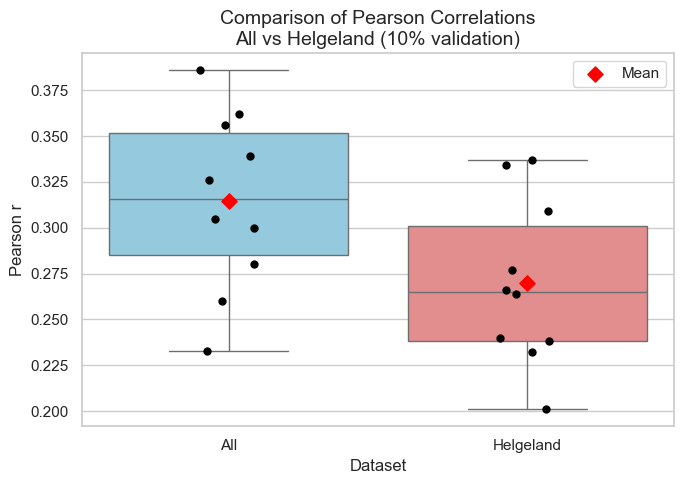

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
pearson_r_all = np.array([0.339, 0.326, 0.280, 0.233, 0.362, 0.300, 0.305, 0.386, 0.356, 0.260])
pearson_r_helgeland = np.array([0.334, 0.337, 0.238, 0.309, 0.277, 0.232, 0.240, 0.201, 0.266, 0.264])

# Combine into dataset
pearson_r = np.concatenate([pearson_r_all, pearson_r_helgeland])
dataset = ["All"] * len(pearson_r_all) + ["Helgeland"] * len(pearson_r_helgeland)

# Plot
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(7, 5))

sns.boxplot(x=dataset, y=pearson_r, palette=["skyblue", "lightcoral"])
sns.stripplot(x=dataset, y=pearson_r, color="black", size=6, jitter=True)

# Add mean markers
means = [pearson_r_all.mean(), pearson_r_helgeland.mean()]
for i, mean in enumerate(means):
    plt.scatter(i, mean, color="red", marker="D", s=60, zorder=10, label="Mean" if i == 0 else "")

plt.title("Comparison of Pearson Correlations\nAll vs Helgeland (10% validation)", fontsize=14)
plt.ylabel("Pearson r", fontsize=12)
plt.xlabel("Dataset", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()
